<a href="https://colab.research.google.com/github/Ajay-user/ML-DL-RL-repo/blob/master/Classification%20Problems/Titanic_classification_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importing data

In [2]:
# https://www.kaggle.com/c/titanic/data
url = 'https://raw.githubusercontent.com/Ajay-user/ML-DL-RL-repo/master/Classification%20Problems/Dataset/titanic.csv'

In [3]:
titanic_df = pd.read_csv(url)
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## Explore the data

In [4]:
(titanic_df.describe()).iloc[:3,:]

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429


In [5]:
# check for null/missing data
titanic_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
# data type
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Baseline predictions
This is a classification problem, here we are predicting whether a person survived or not using the features such as `PassengerId`,	`Pclass`,	`Age`,	`SibSp`,	`Parch`,	`Fare` 

By studying the data we can see that if 'Sex' is Female then the survival rate is 74% , so we can think of a model that predict survived if the sex field is female. Such a naive model can be set as the basline and let see if we can break this 

In [7]:
total_passengers = len(titanic_df)
print('Total number of rows in the dataframe',total_passengers)

percentage_not_survived, percentage_survived=titanic_df['Survived'].value_counts(normalize=True)
print(f'Percentage Survived {percentage_survived :.2f}% Percentage not survived {percentage_not_survived :.2f}%')

male,female = titanic_df['Sex'].value_counts()
print('Male passenger',male)
print('Female passenger',female)

male_survived = titanic_df[(titanic_df['Sex']=='male')&(titanic_df['Survived']==1)]['Sex'].value_counts()['male']
female_survived = titanic_df[(titanic_df['Sex']=='female')&(titanic_df['Survived']==1)]['Sex'].value_counts()['female']
print(f'Male survived {male_survived} male survival rate {(male_survived/male)*100 :.2f}%')
print(f'Female survived {female_survived} female survival rate {(female_survived/female)*100 :.2f}%')


Total number of rows in the dataframe 891
Percentage Survived 0.38% Percentage not survived 0.62%
Male passenger 577
Female passenger 314
Male survived 109 male survival rate 18.89%
Female survived 233 female survival rate 74.20%


## Visualize the data

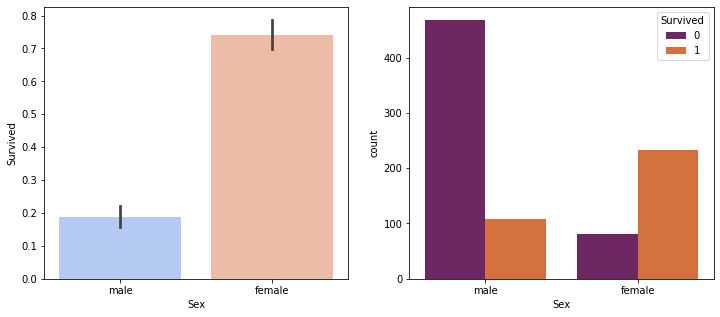

In [8]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.barplot(x='Sex', y='Survived', data=titanic_df ,palette='coolwarm')
plt.subplot(1,2,2)
sns.countplot(x='Sex', data=titanic_df, hue='Survived', palette='inferno')
plt.show()

## Build a Model using Sklearn

In [9]:

# impute missing values using SimpleImputer
from sklearn.impute import SimpleImputer
# Standardize numerical inputs 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
# apply transformation using ColumnTransformer
from sklearn.compose import ColumnTransformer
# Build ML pipeline using Pipeline
from sklearn.pipeline import Pipeline
# cross-validation
from sklearn.model_selection import cross_val_score
# Grid search for hyperparameter tuning
from sklearn.model_selection import GridSearchCV


# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

### Features and Transformations

In [10]:
unique_val = titanic_df.nunique()
for key in titanic_df.columns:
  print(f'{key :15s} data-type {titanic_df[key].dtype !s:10} number of unique values {unique_val[key] :2} ')

PassengerId     data-type int64      number of unique values 891 
Survived        data-type int64      number of unique values  2 
Pclass          data-type int64      number of unique values  3 
Name            data-type object     number of unique values 891 
Sex             data-type object     number of unique values  2 
Age             data-type float64    number of unique values 88 
SibSp           data-type int64      number of unique values  7 
Parch           data-type int64      number of unique values  7 
Ticket          data-type object     number of unique values 681 
Fare            data-type float64    number of unique values 248 
Cabin           data-type object     number of unique values 147 
Embarked        data-type object     number of unique values  3 


In [11]:
# FLOAT COLUMNS / CONTINUES NUMERIC 
numeric_cols = ['Age', 'Fare']
numeric_transformer = Pipeline(steps=[('impute',SimpleImputer(strategy='mean')),('scale',StandardScaler())])

# STRING CATEGORY 
str_cat = ['Sex','Cabin','Embarked']
str_cat_transformer = Pipeline(steps=[('impute',SimpleImputer(strategy='most_frequent')), ('one_hot',OneHotEncoder(handle_unknown='ignore'))])

# INTEGER CATEGORY
int_cat = ['Pclass','SibSp','Parch']
int_cat_transformer = Pipeline(steps=[('impute',SimpleImputer(strategy='median')),('scale',StandardScaler())])

### Preprocessing and Modeling Pipeline

In [12]:
preprocessing = ColumnTransformer(transformers=[
                                                ('numeric', numeric_transformer, numeric_cols), \
                                                ('string', str_cat_transformer, str_cat), \
                                                ('integer', int_cat_transformer, int_cat) \
])

In [13]:
# combine preprocessing and modeling
def build_model(model,preprocess=preprocessing):
  return Pipeline(steps=[('preprocessing', preprocess), ('modeling', model)])

In [14]:
# build a model pipeline 
def model_training(model,X,y):
  pipe = build_model(model)
  return cross_val_score(pipe, X, y)

In [15]:
# list of classification models
models = [('RandomForest',RandomForestClassifier()), \
          ('LogisticRegression',LogisticRegression()), \
          ('GradientBoosting',GradientBoostingClassifier()), \
          ('SVC',SVC()), \
          ('SGDClassifier',SGDClassifier()), \
          ('XGBClassifier',XGBClassifier(use_label_encoder=False, eval_metric='logloss')) \
         ]

### Model comparison

In [16]:
# TRAINING

# Feature variable
X = titanic_df.drop(columns=['Survived'])
# labels
y = titanic_df['Survived']


for name,model in models:
  cv_scores = model_training(model,X,y)
  print(f'Model {name :20s} score: {cv_scores.mean()}')


Model RandomForest         score: 0.8069675475488042
Model LogisticRegression   score: 0.7968551879982425
Model GradientBoosting     score: 0.8204632477559475
Model SVC                  score: 0.8237900947837549
Model SGDClassifier        score: 0.760962902517105
Model XGBClassifier        score: 0.8238152030632101


### Hyperparameter tuning

In [17]:
# Model list with tuning parameters 

models = [('RandomForest', \
           RandomForestClassifier(), \
           {'modeling__max_depth':[i for i in range(4,12)]}), \
          
          ('LogisticRegression', \
           LogisticRegression(), \
           {'modeling__C':[i*0.1 for i in range(10,15)]}), \
          
          ('GradientBoosting', \
           GradientBoostingClassifier(), \
           {'modeling__n_estimators':[i for i in range(100,300,50)]}), \
          
          ('SVC', \
           SVC(), \
           {'modeling__C':[i for i in range(1,10)]}), \
          
          ('SGDClassifier',SGDClassifier(), \
           {'modeling__warm_start':[True,False], \
            'modeling__early_stopping':[True,False], \
            'modeling__average':[True,False]}), \
          
          ('XGBClassifier', \
           XGBClassifier(use_label_encoder=False, eval_metric='logloss'), \
           {'modeling__colsample_bytree':[0.7], \
            'modeling__colsample_bylevel':[0.5], \
            'modeling__colsample_bynode':[0.7], \
            'modeling__subsample':[0.6,0.7]}) \
         ]


In [18]:
# Tuning the model
for name, model, param_grid in models:
    pipe = build_model(model)
    gs = GridSearchCV(pipe, param_grid)
    gs.fit(X,y)
    print(f'{name :20} {gs.best_score_}')

RandomForest         0.8249199673592367
LogisticRegression   0.7979787835038604
GradientBoosting     0.8193333751804659
SVC                  0.8338899001945892
SGDClassifier        0.7991023790094784
XGBClassifier        0.8238340342728014


## Build a model using Tensorflow

In [19]:
# Features and feature types 

features = [*numeric_cols, *int_cat, *str_cat]
feature_types = {feat:titanic_df[feat].dtype for feat in features}
feature_types

{'Age': dtype('float64'),
 'Cabin': dtype('O'),
 'Embarked': dtype('O'),
 'Fare': dtype('float64'),
 'Parch': dtype('int64'),
 'Pclass': dtype('int64'),
 'Sex': dtype('O'),
 'SibSp': dtype('int64')}

In [44]:
# Input features
inputs = {}
for k,v in feature_types.items():
  inputs[k]=tf.keras.Input(shape=(1,), dtype=v, name=k)
inputs

{'Age': <KerasTensor: shape=(None, 1) dtype=float64 (created by layer 'Age')>,
 'Cabin': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Cabin')>,
 'Embarked': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Embarked')>,
 'Fare': <KerasTensor: shape=(None, 1) dtype=float64 (created by layer 'Fare')>,
 'Parch': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'Parch')>,
 'Pclass': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'Pclass')>,
 'Sex': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Sex')>,
 'SibSp': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'SibSp')>}

It you're passing a heterogenous DataFrame to Keras, each column may need unique preprocessing. You could do this preprocessing directly in the DataFrame, but for a model to work correctly, inputs always need to be preprocessed the same way. So, the best approach is to build the preprocessing into the model.


Note: If you have many features that need identical preprocessing it's more efficient to concatenate them together befofre applying the preprocessing.

### Encoding

In [45]:
# preprocessing 

def stack_features(df,cols):
  feat=[]
  for k in sorted(df.keys()):
    if k in cols:
      feat.append(k)
  return df[feat]

def transformer(name,transformer,cols,df):
  df = stack_features(df, cols)
  transformer = ColumnTransformer([(name,transformer,cols)])
  return transformer.fit_transform(df)

def numerical_encoding(features, df):
  transformed_df = transformer('numeric', SimpleImputer(strategy='mean'), numeric_cols, df)
  normalizer = tf.keras.layers.Normalization()
  normalizer.adapt(transformed_df)
  return normalizer(features)

def integer_cat_encoding(features, df):
  transformed_df = transformer('int_cat', SimpleImputer(strategy='median'), int_cat, df)
  lookup = tf.keras.layers.experimental.preprocessing.IntegerLookup()
  lookup.adapt(transformed_df)
  cat_encode = tf.keras.layers.experimental.preprocessing.CategoryEncoding(num_tokens=lookup.vocabulary_size())
  return cat_encode(lookup(features))

def string_cat_encoding(features, df):
  transformed_df = transformer('str_cat', SimpleImputer(strategy='most_frequent'), str_cat, df)
  lookup = tf.keras.layers.experimental.preprocessing.StringLookup()
  lookup.adapt(transformed_df)
  cat_encode = tf.keras.layers.experimental.preprocessing.CategoryEncoding(num_tokens=lookup.vocabulary_size())
  return cat_encode(lookup(features))

In [46]:
all_encoded=[]

# Numerical encoding
feature_input = [inputs[feat] for feat in sorted(numeric_cols)]
numerical_features = tf.keras.layers.concatenate(feature_input)
encoding = numerical_encoding(numerical_features, titanic_df)
all_encoded.append(encoding)
encoding


<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'normalization_8')>

In [47]:
# Category encoding 

# integer category
feature_input = [inputs[feat] for feat in sorted(int_cat)]
integer_features = tf.keras.layers.concatenate(feature_input)
all_encoded.append(integer_cat_encoding(integer_features,titanic_df)) 

# string category
feature_input = [inputs[feat] for feat in sorted(str_cat)]
string_features = tf.keras.layers.concatenate(feature_input)
all_encoded.append(string_cat_encoding(string_features,titanic_df))

all_encoded

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'normalization_8')>,
 <KerasTensor: shape=(None, 9) dtype=float32 (created by layer 'category_encoding_4')>,
 <KerasTensor: shape=(None, 153) dtype=float32 (created by layer 'category_encoding_5')>]

### Building the model

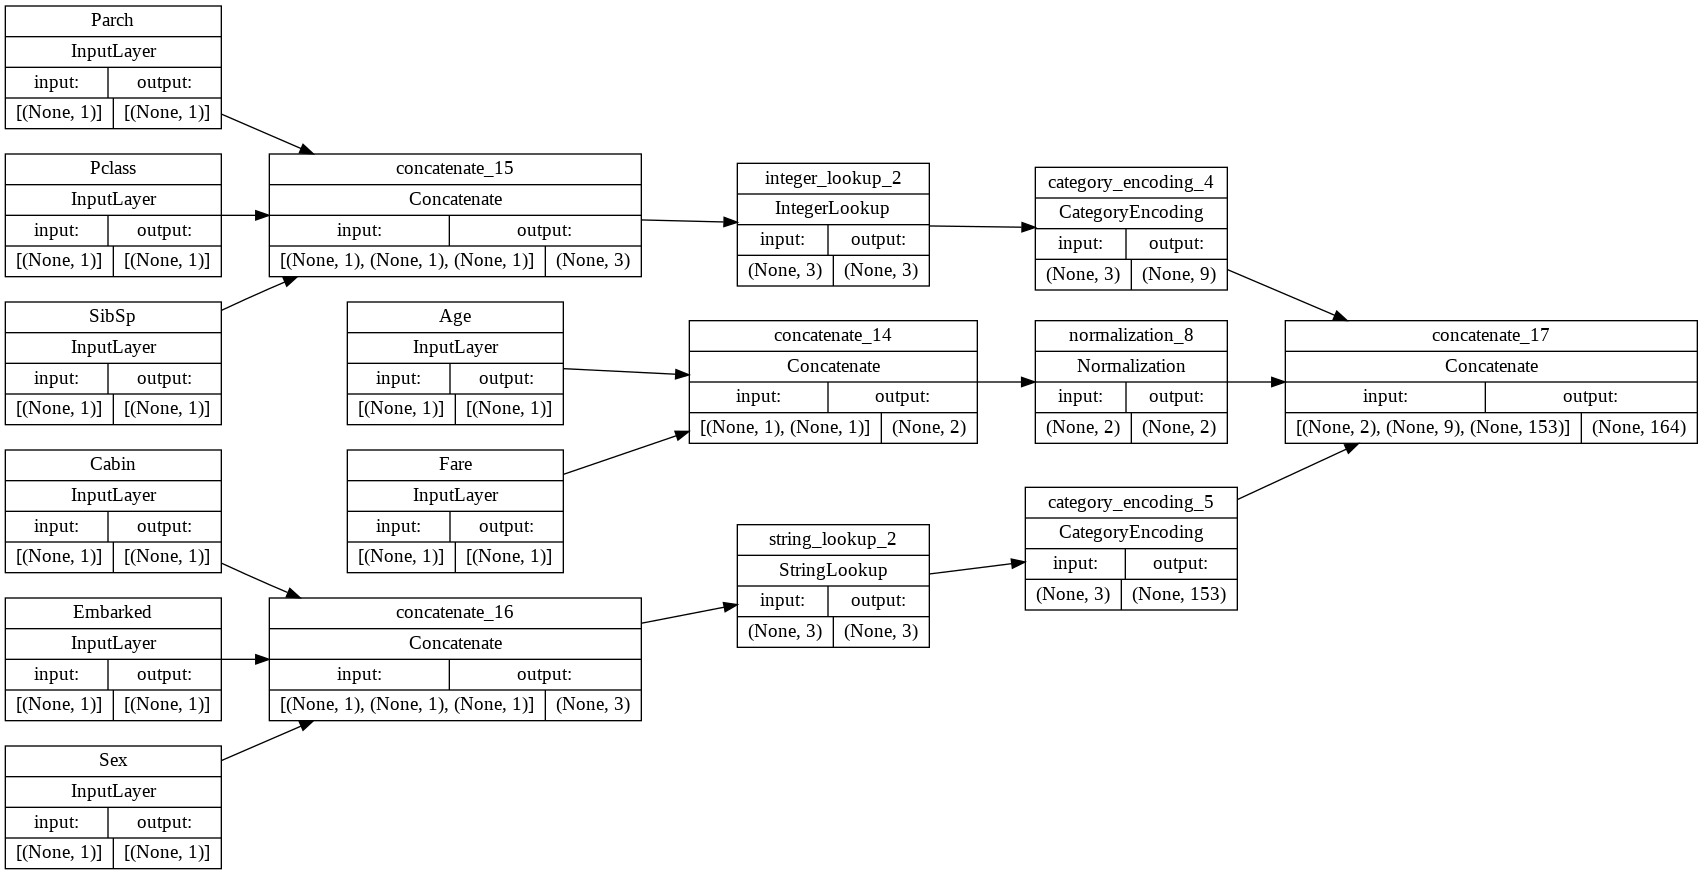

In [48]:
# keras preprocessing head

feature_prep = tf.keras.layers.concatenate(all_encoded)
titanic_preprocessor = tf.keras.Model(inputs, feature_prep)

tf.keras.utils.plot_model(titanic_preprocessor, show_shapes=True, rankdir='LR')


In [49]:
# Tensorflow Sequential model
fully_connected = tf.keras.Sequential([
                                       tf.keras.layers.Dense(32,'relu'),
                                       tf.keras.layers.Dense(16,'relu'),
                                       tf.keras.layers.Dense(1)
])

In [50]:
def build_tf_model(inputs, preprocessor, sequential):
  prep = preprocessor(inputs)
  results = sequential(prep)
  model = tf.keras.Model(inputs, results)

  # compile the model
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), \
                optimizer='adam', \
                metrics=['accuracy'])
  return model

In [51]:
tf_model = build_tf_model(inputs, \
                          titanic_preprocessor, \
                          fully_connected)

In [52]:
# TRAINING DATA
training_data={}
for k,v in feature_types.items():
  na_impute = 'missing' if v=='object' else -1
  vals = titanic_df[k].fillna(na_impute)
  training_data[k]= np.array(vals)

training_label=titanic_df['Survived']


### Training the model

In [54]:
history = tf_model.fit(training_data, training_label, epochs=10)

Epoch 1/10
28/28 [==============================] - 1s 3ms/step - loss: 0.6465 - accuracy: 0.6162
Epoch 2/10
28/28 [==============================] - 0s 3ms/step - loss: 0.5791 - accuracy: 0.6341
Epoch 3/10
28/28 [==============================] - 0s 2ms/step - loss: 0.5102 - accuracy: 0.7464
Epoch 4/10
28/28 [==============================] - 0s 3ms/step - loss: 0.4649 - accuracy: 0.7856
Epoch 5/10
28/28 [==============================] - 0s 3ms/step - loss: 0.4427 - accuracy: 0.7991
Epoch 6/10
28/28 [==============================] - 0s 2ms/step - loss: 0.4337 - accuracy: 0.8148
Epoch 7/10
28/28 [==============================] - 0s 3ms/step - loss: 0.4231 - accuracy: 0.8137
Epoch 8/10
28/28 [==============================] - 0s 2ms/step - loss: 0.4146 - accuracy: 0.8159
Epoch 9/10
28/28 [==============================] - 0s 3ms/step - loss: 0.4078 - accuracy: 0.8193
Epoch 10/10
28/28 [==============================] - 0s 2ms/step - loss: 0.4016 - accuracy: 0.8361


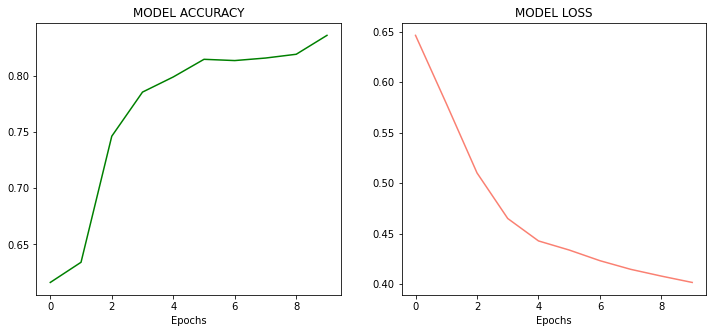

In [67]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],color='green')
plt.title("MODEL ACCURACY")
plt.xlabel('Epochs')
plt.subplot(1,2,2)
plt.plot(history.history['loss'],color='salmon')
plt.title("MODEL LOSS")
plt.xlabel('Epochs')
plt.show()

In [58]:
loss

'accuracy'